#### 从Assets/ExpLog中提取json文件进行处理. 结果暂存为.csv以方便使用excel.

**注意json中的firsttouch的目标不可靠，坐标应该对应inputsequence中删去-+的区域**

In [11]:
# 导入包，设置路径
import numpy as np
from openpyxl import Workbook
import os
import json
import csv
from EditDistance import EditDistance
import math
import matplotlib.pyplot as plt

LogDir = "D:/Unity/Project/Keyboard/Assets/ExpLog/"

In [3]:
# 获取json文件列表，并以名称为索引
tmpfList = os.listdir(LogDir)
fDist = {}   # "name" : [0's filename, 1's filename, 2's filename, 3's filename..]
nameList = []
typeList = ["NSPad", "NSPad+Crossover", "FanPad", "FanPad+Crossover"]
typenum = 4

for fname in tmpfList:
    if not fname.endswith(".json"):
        continue
    n, t, time = fname[:-5].split('_')
    t = int(t)
    try:
        nameList.index(n)
    except ValueError:
        nameList.append(n)
    if n not in fDist.keys():
        fDist[n] = [None, None, None, None]
    if fDist[n][t] is not None:
        _, _, another_time = fname[:-5].split('_')
        if another_time < time:
            # 使用更晚的.
            fDist[n][t] = fname
    else:
        fDist[n][t] = fname

In [10]:
# 手动添加需要的数据.
typeList = ["NSPad", "NSPad+Crossover", "FanPad", "FanPad+Crossover"]
typenum = 4
nameList = ['cx','fjy','ljh0','ljh1','lyc','zby','wzt0','wzt1','dyh0','dyh1','lhz','zzc',]
fDist = {
    'cx': ["cx_0_20230906145018.json","cx_1_20230906145940.json","cx_2_20230906152153.json","cx_3_20230906153834.json"],
    'fjy':["fjy_0_20230906161701.json","fjy_1_20230906162310.json","fjy_2_20230906163502.json","fjy_3_20230906164216.json"],
    'lhz':["lhz_0_20230906210930.json","lhz_1_20230906211641.json","lhz_2_20230906213738.json","lhz_3_20230906214306.json"],
    'ljh0':["ljh_0_20230909220035.json","ljh_1_20230909221724.json","ljh_2_20230910175013.json","ljh_3_20230910212310.json"],
    'ljh1':["ljh_0_20230905192925.json","ljh_1_20230910210843.json","ljh_2_20230905200845.json","ljh_3_20230910175432.json"],
    'lyc':["lyc_0_20230904142102.json","lyc_1_20230904142651.json","lyc_2_20230904152622.json","lyc_3_20230904153338.json"],
    'zby':["zby_0_20230904195551.json","zby_1_20230904200137.json","zby_2_20230904201144.json","zby_3_20230904202246.json"],
    'zzc':['zzc_0_20230904214557.json','zzc_1_20230904215930.json','zzc_2_20230904222905.json','zzc_3_20230904223736.json'],
    'wzt0':['wzt_0_20230907113211.json','wzt_1_20230910192840.json','wzt_2_20230907113903.json','wzt_3_20230909223047.json'],
    'wzt1':['wzt_0_20230910192342.json','wzt_1_20230907113532.json','wzt_2_20230910143827.json','wzt_3_20230910150343.json'],
    'dyh0':['dyh_0_20230904205330.json','dyh_1_20230910213640.json','dyh_2_20230916184417.json','dyh_3_20230916183156.json'],
    'dyh1':['dyh_0_20230910213235.json','dyh_1_20230904210151.json','dyh_2_20230913214131.json','dyh_3_20230913214611.json'],
}


In [19]:
print(nameList)
print(fDist)

['cx', 'fjy', 'lhz', 'ljh0', 'ljh1', 'lyc', 'zby', 'zzc', 'wzt0', 'wzt1']
{'cx': ['cx_0_20230906145018.json', 'cx_1_20230906145940.json', 'cx_2_20230906152153.json', 'cx_3_20230906153834.json'], 'fjy': ['fjy_0_20230906161701.json', 'fjy_1_20230906162310.json', 'fjy_2_20230906163502.json', 'fjy_3_20230906164216.json'], 'lhz': ['lhz_0_20230906210930.json', 'lhz_1_20230906211641.json', 'lhz_2_20230906213738.json', 'lhz_3_20230906214306.json'], 'ljh0': ['ljh_0_20230909220035.json', 'ljh_1_20230909221724.json', 'ljh_2_20230910175013.json', 'ljh_3_20230910212310.json'], 'ljh1': ['ljh_0_20230905192925.json', 'ljh_1_20230910210843.json', 'ljh_2_20230905200845.json', 'ljh_3_20230910175432.json'], 'lyc': ['lyc_0_20230904142102.json', 'lyc_1_20230904142651.json', 'lyc_2_20230904152622.json', 'lyc_3_20230904153338.json'], 'zby': ['zby_0_20230904195551.json', 'zby_1_20230904200137.json', 'zby_2_20230904201144.json', 'zby_3_20230904202246.json'], 'zzc': ['zzc_0_20230904214557.json', 'zzc_1_202309042

In [3]:
# 准备一些需要使用的函数.
def TotalError(phrases:list[str], inputSequence: list[str]):
    # 计算输入过程中的总错误数..先还是用下标按顺序来吧..
    allPhrase = "\n".join(phrases).lower()
    cur = ""
    ind = 0
    err = 0
    for next in inputSequence:
        next = next.lower()
        if next == "back":
            cur = cur[:-1]
            ind = 0 if ind == 0 else ind - 1
            next = ""
        elif next == "sym" or next == "shift":
            # 直接忽略
            next = ""
        elif next[0] == '-':
            delete, add = next.split(", ")
            cur = cur[:-(len(delete)-1)] + add[1:]
            ind = ind - len(delete) + 1
            next = add[1:]
        else:
            cur = cur + next
        # 接下来是比较.
        for j in range(len(next)):
            if allPhrase[i] != next[j]:
                if allPhrase[i] == "\n" and next[j] == ' ':
                    i -= 1
                else:
                    err += 1
            i += 1
    return err

# 用back总次数算.
def BackTimes(inputSequence : list[str]):
    err = 0
    for i in inputSequence:
        if i == "Back":
            err += 1
    return err

In [10]:
# 计算所有 json 的错误率, 并且更新json.
for fname in os.listdir(LogDir):
    if not fname.endswith(".json"):
        continue
    p = os.path.join(LogDir, fname)
    with open(p, "r") as f:
        content = json.load(f)
    time = content["seconds"]
    length = content["phraseLength"]
    # 算错误率
    phrases = content["phrases"]
    phrases = ' '.join(phrases).lower()
    result = content["result"].split("\n")
    for j in range(len(result)):
        result[j] = result[j].strip()
    result = ' '.join(result).lower()
    # print(phrases)
    # print(result)
    ncerr = EditDistance(phrases, result)
    totalerr = ncerr + BackTimes(content["inputSequence"])
    content["NCER"] = ncerr / length
    content["TER"] = totalerr / length
    with open(p, "w") as f:
        json.dump(content, f, indent=4)

In [11]:
# 保存数据到xlsx中.
head = ['name', 'time', 'length', 'WPM', 'TER', 'NCER']

wb = Workbook()

for i in range(typenum):
    rows = []
    ws = wb.create_sheet(typeList[i], i)
    ws.append(head)
    for user in nameList:
        # print(user, i)
        file = fDist[user][i]
        if file is None:
            continue
        else:
            file = os.path.join(LogDir, file)
            with open(file, "r") as f:
                jsonFile = json.load(f)
            time = jsonFile["seconds"]
            length = jsonFile["phraseLength"]
            WPM = jsonFile["WPM"]
            # 算错误率
            phrases = jsonFile["phrases"]
            phrases = ' '.join(phrases).lower()
            result = jsonFile["result"].split("\n")
            for j in range(len(result)):
                result[j] = result[j].strip()
            result = ' '.join(result).lower()
            # print(phrases)
            # print(result)
            ncerr = EditDistance(phrases, result)
            # for j in range(len(phrases)):
            #     result[j] = result[j].strip()
            #     ncerr += EditDistance(phrases[j], result[j])
            totalerr = ncerr + BackTimes(jsonFile["inputSequence"])
            rows.append([user, time, length, WPM, totalerr/length, ncerr/length])
            ws.append([user, time, length, WPM, totalerr/length, ncerr/length])
    # 保存到csv中
    # with open(os.path.join("./", typeList[i] + "_speed_err.csv"), "w", encoding="utf-8-sig", newline="") as f:
    #     csv_writer = csv.writer(f)
    #     csv_writer.writerow(head)
    #     csv_writer.writerows(rows)
wb.save(os.path.join("./", "Speed_Err_shadowclone.xlsx"))

In [8]:
# 长时间使用. 把 wzt_2,wzt_3和ljh_2,ljh_3排个序. 然后保存到LongtimeUse.xlsx
class WTN:
    # WPM, TER, NCER
    def __init__(self, wpm, ter, ncer) -> None:
        self.wpm = wpm
        self.ter = ter
        self.ncer = ncer

def getKey_WTN(wtn:WTN):
    return wtn.wpm
        

wanted = ['wzt_2', 'wzt_3', 'ljh_2', 'ljh_3']
data = {}
for i in wanted:
    data[i] = []
for fname in os.listdir(LogDir):
    if not fname.endswith(".json"):
        continue
    info = fname[:-5].split('_')
    name_type = '_'.join(info[:2])
    if name_type in wanted:
        with open(os.path.join(LogDir, fname)) as f:
            content = json.load(f)
        wpm = content["WPM"]
        ter = content["TER"]
        ncer = content["NCER"]
        data[name_type].append(WTN(wpm, ter, ncer))

# 排序并输出
for name_type in wanted:
    data[name_type].sort(key=getKey_WTN)
wb = Workbook()
ws = wb.create_sheet("sorted")
for name_type in wanted:
    row_wpm = [name_type+'_WPM']
    row_ter = [name_type+'_TER']
    row_ncer = [name_type+'_NCER']
    for entity in data[name_type]:
        row_wpm.append(entity.wpm)
        row_ter.append(entity.ter)
        row_ncer.append(entity.ncer)
    ws.append(row_wpm)
    ws.append(row_ter)
    ws.append(row_ncer)
wb.save("LongtimeUse.xlsx")

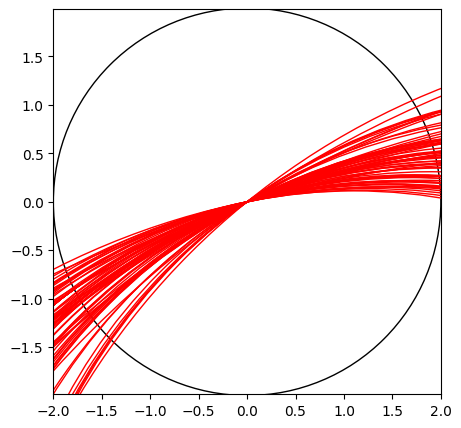

In [22]:
# 根据所有theta R 画圆.
x = 5  # 圆心的x轴坐标
y = 5  # 圆心的y轴坐标
r = 3  # 圆的半径

# 画圆
fig = plt.figure(figsize=(5, 5))

def draw_circle(center_x, center_y, radius, color):
    circle = plt.Circle((center_x, center_y), radius, color=color, fill=False)
    plt.gcf().gca().add_artist(circle)

# touchpad
draw_circle(0,0, 2, 'black')

# thetaR
for fname in os.listdir(LogDir):
    if not fname.endswith(".json"):
        continue
    info = fname[:-5].split('_')
    if int(info[1]) == 2 or int(info[1]) == 3:
        with open(os.path.join(LogDir, fname)) as f:
            content = json.load(f)
        theta = content['theta']
        r = content['r']
        # 计算圆心.
        center_x = r*np.sin(theta)
        center_y = -r*np.cos(theta)
        draw_circle(center_x, center_y, r, 'r')

plt.axis('equal')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

**下面是关于firsttouch的东西.**
+ firstTouch中的目标key，因为可能index可能错位，所以不可靠.
+ 应该用firstTouch中的坐标和 inputSequence 配对.
+ FanPads可能有fitting, fitting全都记录了firstTouch，应该删除开头一连串目标key一样的firstTouch，只留最后一个.
+ **正确的数据，应该按照type，按照字母，统一分类坐标。现在没有区分type**

In [2]:
# helper functions
usable_date = "20230908000000"
def getUsableFirstTouchAfter0908():
    ret = []
    for f in os.listdir(LogDir):
        if not f.endswith('.json'):
            continue
        _, _, date = f[:-5].split('_')
        if date > usable_date:
            ret.append(f)
    return ret

def clean_inputSequence(inputsequence):
    # 去掉inputsequence中的-+,以及后面跟着的空格.
    ret = []
    i = 0
    while i < len(inputsequence):
        if inputsequence[i][0] == '-':
            i += 1
        else:
            ret.append(inputsequence[i])
        i += 1
    return ret

def clean_firsttouch(inputsequence, firsttouch):
    '''
    WARNING: 这个只针对9.7晚上修改experiment之前的版本有用.删掉firstouch前面无故重复的部分
    '''
    back_at_start_times = 0  # 出现在开头的back次数.
    for tmp in inputsequence:
        if tmp != "Back":
            break
        back_at_start_times+=1
    firstKey = firsttouch[0]['key']
    for j in range(len(firsttouch)):
        if firstKey != firsttouch[j]['key']:
            break
    return firsttouch[j-1-back_at_start_times:]


# 获取json名字，类型，日期.
def getJsonInfo(jsonname:str):
    info = jsonname[:-5].split('_')
    #print(info)
    return info[0], info[1], info[2]


In [15]:
def saveFirstTouchIntoXlsx(firsttouches:list, thetaR:list, jsonname:list, filename:str):
    '''
    把firsttouch中的所有文件的firsttouch保存到filename的xlsx中，每个文件都占用一个worksheet.  
    最后一行记录 theta, r, 以及各个字母的平均距离——只有之前的能统计打错左右手的数据..
    '''
    # 形成表头.
    alphas = []
    for i in range(26):
        alphas += [chr(ord('a')+i)]
    for i in [" ","Back", "Enter", "Shift", "Sym"]:
        alphas += [i]

    top = [3] * len(alphas)  # top是要写入的行数.used in cell
    dis = [0] * len(alphas)
    wb = Workbook()
    for i in range(len(jsonname)):
        firsttouch = firsttouches[i]
        ws = wb.create_sheet(jsonname[i][:-5])
        personname, kbdtype, date = getJsonInfo(jsonname[i])
        # 写入表头.
        ws.append([alphas[j//4] if j%4 == 0 else "" for j in range(4*len(alphas))])
        # 合并第一行.
        for j in range(1, len(alphas)+1):
            ws.merge_cells(start_row = 1, start_column = 4*j - 3, end_row = 1, end_column = 4*j)
        
        ws.append(["lr", "x", "y", "distance"] * len(alphas))

        # 遍历firsttouch
        for entry in firsttouch:
            if not entry['key'] in alphas:
                continue
            if abs(entry['x']) > 1.5 or abs(entry['y']) > 1.5:
                continue  # 舍弃那个占位的back
            index = alphas.index(entry['key'])
            d = computeDistance((entry['x'], entry['y']), entry['lr'], entry['key'], kbdtype, thetaR[i][0], thetaR[i][1])
            ws.cell(row = top[index], column = 4*index+1, value = entry['lr'])
            ws.cell(row = top[index], column = 4*index+2, value = entry['x'])
            ws.cell(row = top[index], column = 4*index+3, value = entry['y'])
            if type(d) != str:
                ws.cell(row = top[index], column = 4*index+4, value = d)
                dis[index] += d
            else:
                ws.cell(row = top[index], column = 4*index+4, value = 0)  # wrong hand
            top[index] += 1
            
        # [theta, r, mean of all the distance]
        sum_dis = 0
        sum_points = 0
        for j in range(len(alphas)):
            sum_dis += dis[j]
            sum_points+= top[j] - 3
        ws.append([thetaR[i][0], thetaR[i][1], sum_dis / sum_points])
    
    # 最后保存
    wb.save(filename)


def computeDistance(coord, lr, key, kbdtype, theta = 0.3, r = 6):
    if type(kbdtype) == str:
        kbdtype = int(kbdtype)
    if kbdtype == 0:
        layout = [
            [
                ['q', 'w', 'e', 'r', 't'],
                ['a', 's', 'd', 'f', 'g'],
                ['Shift', 'z', 'x', 'c', 'v'],
                ['Sym', ',', ' '],
            ],
            [
                ['y','u','i','o','p'],
                ['g','h','j','k','l'],
                ['v','b','n','m','Back'],
                [' ', '.', 'Enter'],
            ]
        ]
        row_center = [-0.75, -0.275, 0.175, 0.7]  # 各行的中心y坐标
    elif kbdtype == 1:
        layout = [
            [
                ['q', 'w', 'e', 'r', 't','y'],
                ['a', 's', 'd', 'f', 'g','h'],
                ['Shift', 'z', 'x', 'c', 'v', 'b'],
                ['Sym', ',', ' '],
            ],
            [
                ['t', 'y','u','i','o','p'],
                ['f', 'g','h','j','k','l'],
                ['c', 'v','b','n','m','Back'],
                [' ', '.', 'Enter'],
            ]
        ]
        row_center = [-0.75, -0.275, 0.175, 0.7]  # 各行的中心
    elif kbdtype == 2:
        layout = [
            [
                ['Shift', '?', '.'],
                ['q', 'w', 'e', 'r', 't'],
                ['a', 's', 'd', 'f', 'g'],
                ['z', 'x', 'c', 'v'],
                ['Sym', ' '],
            ],
            [
                [',', '!', 'Back'],
                ['y','u','i','o','p'],
                ['g','h','j','k','l'],
                ['v','b','n','m'],
                [' ', 'Enter'],
            ]
        ]
        row_center = [-0.8, -0.4, 0, 0.4, 0.8]
    else:
        layout = [
            [
                ['Shift', '?', '.'],
                ['q', 'w', 'e', 'r', 't','y'],
                ['a', 's', 'd', 'f', 'g','h'],
                ['z', 'x', 'c', 'v', 'b'],
                ['Sym', ' '],
            ],
            [
                [',', '!', 'Back'],
                ['t', 'y','u','i','o','p'],
                ['f', 'g','h','j','k','l'],
                ['c', 'v','b','n','m'],
                [' ', 'Enter'],
            ]
        ]
        row_center = [-0.8, -0.4, 0, 0.4, 0.8]

    foundkey = False
    for row in range(len(row_center)):
        try:
            index = layout[lr][row].index(key)
            foundkey = True
            break
        except:
            pass
    
    if not foundkey:
        # 左右手错了.
        return "wrong hand"
    
    # 计算中心的坐标.
    if kbdtype == 0 or kbdtype == 1:
        width = math.sqrt(1 - row_center[row]**2) * 2
        span = width / len(layout[lr][row])
        key_center = np.array([-1+span/2+span*index, row_center[row]])
        print("nspad, ", key_center)
    else:
        circle_center = np.array((math.sin(theta)*(r - row_center[row]), -math.cos(theta)*(r - row_center[row])))
        # 先求y.
        k1 = - (circle_center[1] / circle_center[0])
        b1 = (circle_center[0]**2+circle_center[1]**2+4-r**2) / (2*circle_center[0])
        k12 = k1**2
        b12 = b1**2
        delta = 4*k12*b12 - 4*(k12+1)*(b12-4)
        yl = (-2*k1*b1 - np.sqrt(delta)) / 2*(k12+1)
        yr = (-2*k1*b1 + np.sqrt(delta)) / 2*(k12+1)
        xl = k1*yl + b1
        xr = k1*yr + b1
        left_vec = np.array((xl, yl)) - circle_center
        right_vec = np.array((xr, yr)) - circle_center
        # 大圆小圆交点与大圆中心形成了左右两个向量的夹角.
        alpha = np.arccos(np.dot(left_vec, right_vec)/np.sum(left_vec**2))
        span = alpha / len(layout[lr][row])
        rot_angle = -span*index  # 是旋转矩阵的转角是逆时针转的.这里需要顺时针转
        mat = np.array([
                [np.cos(rot_angle), -np.sin(rot_angle)],
                [np.sin(rot_angle), np.cos(rot_angle)]
            ])
        key_center = np.matmul(mat, left_vec) + circle_center
        print("fanpad, ", key_center)

    # 计算距离.
    coord = np.array(coord)
    return np.sqrt(np.sum((coord - key_center)**2))

In [4]:
# 获取可靠的序列.
usable_first_touch = [
    "dyh_0_20230904205330.json",
    "wzt_0_20230907113211.json",
    "zby_0_20230904195551.json",
    "cx_1_20230906145940.json",
    "dyh_2_20230904211745.json",
    "cyl_3_20230906180500.json",
    "zzc_3_20230904223736.json",
]
usable_first_touch += getUsableFirstTouchAfter0908()
print(usable_first_touch)

['dyh_0_20230904205330.json', 'wzt_0_20230907113211.json', 'zby_0_20230904195551.json', 'cx_1_20230906145940.json', 'dyh_2_20230904211745.json', 'cyl_3_20230906180500.json', 'zzc_3_20230904223736.json', 'dyh_0_20230910213235.json', 'dyh_1_20230910213640.json', 'dyh_2_20230910214313.json', 'dyh_2_20230910215414.json', 'dyh_3_20230910220022.json', 'ljh_0_20230909211939.json', 'ljh_0_20230909220035.json', 'ljh_0_20230910174134.json', 'ljh_0_20230910210401.json', 'ljh_1_20230909221724.json', 'ljh_1_20230910174545.json', 'ljh_1_20230910210843.json', 'ljh_2_20230909222439.json', 'ljh_2_20230910120444.json', 'ljh_2_20230910175013.json', 'ljh_2_20230910211737.json', 'ljh_3_20230910175432.json', 'ljh_3_20230910212310.json', 'ljh_3_20230910212702.json', 'wzt_0_20230910111610.json', 'wzt_0_20230910192342.json', 'wzt_1_20230910112004.json', 'wzt_1_20230910192840.json', 'wzt_2_20230910143827.json', 'wzt_2_20230910193418.json', 'wzt_2_20230911124522.json', 'wzt_3_20230909223047.json', 'wzt_3_2023091

In [16]:
# 测试上面的东西.
ljh_json = []
firstTouches = []
thetaR = []
for jsonname in usable_first_touch:
    name, kbdtype, date = getJsonInfo(jsonname)
    if name == 'ljh':
        ljh_json.append(jsonname)
        with open(os.path.join(LogDir, jsonname), "r") as f:
            content = json.load(f)
        firstTouches.append(content['firstTouches'])
        thetaR.append([content['theta'], content['r']])
print(ljh_json)      
saveFirstTouchIntoXlsx(firstTouches, thetaR, ljh_json, "./ljh_first.xlsx")

['ljh_0_20230909211939.json', 'ljh_0_20230909220035.json', 'ljh_0_20230910174134.json', 'ljh_0_20230910210401.json', 'ljh_1_20230909221724.json', 'ljh_1_20230910174545.json', 'ljh_1_20230910210843.json', 'ljh_2_20230909222439.json', 'ljh_2_20230910120444.json', 'ljh_2_20230910175013.json', 'ljh_2_20230910211737.json', 'ljh_3_20230910175432.json', 'ljh_3_20230910212310.json', 'ljh_3_20230910212702.json']
nspad,  [ 0.19058809 -0.75      ]
nspad,  [-0.86771243 -0.75      ]
nspad,  [0.37839581 0.175     ]
nspad,  [-0.33856217 -0.75      ]
nspad,  [ 0.19058809 -0.75      ]
nspad,  [ 0.19058809 -0.75      ]
nspad,  [ 0.73059961 -0.275     ]
nspad,  [-0.07398704 -0.75      ]
nspad,  [-0.76195239  0.7       ]
nspad,  [-0.42313346 -0.275     ]
nspad,  [-0.42313346 -0.275     ]
nspad,  [-0.07398704 -0.75      ]
nspad,  [ 0.19058809 -0.75      ]
nspad,  [ 0.19058809 -0.75      ]
nspad,  [ 0.34602192 -0.275     ]
nspad,  [-0.01543157  0.175     ]
nspad,  [ 0.73059961 -0.275     ]
nspad,  [0.190238

C:\Users\admin\AppData\Local\Temp\ipykernel_3876\3467162880.py:164: RuntimeWarning: invalid value encountered in arccos
  alpha = np.arccos(np.dot(left_vec, right_vec)/np.sum(left_vec**2))


fanpad,  [nan nan]
fanpad,  [-64.62532771  68.98976018]
fanpad,  [-68.35945748  25.24279771]
fanpad,  [-96.71411986  17.06987971]
fanpad,  [nan nan]
fanpad,  [-50.72886345  49.41586261]
fanpad,  [-84.54377097  45.42415317]
fanpad,  [-64.62532771  68.98976018]
fanpad,  [nan nan]
fanpad,  [-64.62532771  68.98976018]
fanpad,  [nan nan]
fanpad,  [-64.62532771  68.98976018]
fanpad,  [-50.72886345  49.41586261]
fanpad,  [nan nan]
fanpad,  [-64.62532771  68.98976018]
fanpad,  [-75.91840057  -3.70607604]
fanpad,  [-96.71411986  17.06987971]
fanpad,  [nan nan]
fanpad,  [-96.71411986  17.06987971]
fanpad,  [-68.35945748  25.24279771]
fanpad,  [-75.91840057  -3.70607604]
fanpad,  [nan nan]
fanpad,  [-64.62532771  68.98976018]
fanpad,  [-84.54377097  45.42415317]
fanpad,  [-72.3565433  -33.41277705]
fanpad,  [nan nan]
fanpad,  [nan nan]
fanpad,  [-100.07585212  -13.60227333]
fanpad,  [ 3.90080684 71.14262651]
fanpad,  [-84.54377097  45.42415317]
fanpad,  [nan nan]
fanpad,  [-75.91840057  -3.706076

In [17]:
# firstTouch, 但是现有的firstTouch并不可靠..
# 先按type做worksheet，按人来记录. 先全部记录下来，不管是否对的上.
# 把所有人的都合在一起了，用不了.
wb = Workbook()
# 普通wb的表头.
head_template = ["", 'key', 'lr', 'x', 'y']
unit = len(head_template)
ws_right_alpha = wb.create_sheet("alpha_correct", typenum)
# right_alpha的表头.
alphas = []
alphaDist = {}
for i in range(26):
    alphas += [chr(ord('a')+i)]
    alphaDist[chr(ord('a')+i)] = []
for i in [" ","Back", "Enter", "Shift", "Sym"]:
    alphas += [i]
    alphaDist[i] = []

# 记录firstTouch数据
for i in range(typenum):
    ws = wb.create_sheet(typeList[i], i)
    head = head_template * len(nameList)
    rows = []
    for name_index in range(len(nameList)):
        name = nameList[name_index]
        head[unit*name_index] = name
        file = fDist[name][i]
        if file is not None:
            with open(os.path.join(LogDir, file), "r") as f:
                jsonFile = json.load(f)
            inputSeq = []
            inputSeqTemp = jsonFile["inputSequence"]
            firstTouch = jsonFile["firstTouches"]
            # 删去inputSeq中的-,+, 以及后面紧跟的空格.
            j = 0
            while j < len(inputSeqTemp):
                if inputSeqTemp[j][0] == '-':
                    j += 1
                else:
                    inputSeq.append(inputSeqTemp[j])
                j += 1
            if i==2 or i==3:
                # 除掉firstTouch中开头重叠的部分.
                back_at_start_times = 0  # 出现在开头的back次数.
                for tmp in inputSeq:
                    if tmp != "Back":
                        break
                    back_at_start_times+=1
                firstKey = firstTouch[0]['key']
                for j in range(len(firstTouch)):
                    if firstKey != firstTouch[j]['key']:
                        break
                firstTouch = firstTouch[j-1-back_at_start_times:]
            
            if len(inputSeq) == len(firstTouch):
                # 正确的.按字母记录坐标.
                print(file)
                for j in range(len(inputSeq)):
                    try:
                        alphaDist[inputSeq[j]].append([firstTouch[j]['lr'],firstTouch[j]['x'], firstTouch[j]['y']])
                    except:
                        alphas.append(inputSeq[j])
                        alphaDist[inputSeq[j]] = [firstTouch[j]['lr'], firstTouch[j]['x'], firstTouch[j]['y']]

            # 保存到rows中.key用inputSeq, lr,x,y用firstTouch
            for j in range(len(inputSeq)):
                try:
                    rows[j][name_index * unit + 1] = inputSeq[j]
                except:
                    rows.append([""] * unit * len(nameList))
                    rows[j][name_index * unit + 1] = inputSeq[j]
            for j in range(len(firstTouch)):
                try:
                    rows[j][name_index * unit + 2] += ['l' if firstTouch[j]['lr']==0 else 'r']
                except:
                    rows.append([""] * unit * len(nameList))
                    rows[j][name_index * unit + 2] = 'l' if firstTouch[j]['lr']==0 else 'r'
                rows[j][name_index * unit + 3] = firstTouch[j]['x']
                rows[j][name_index * unit + 4] = firstTouch[j]['y']
    # 按type和人物写入ws
    ws.append(head)
    for row in rows:
        ws.append(row)


# 保存正确的firstTouch, 按照字母顺序.
# 表头，alphas and x,y
# 每个字母后面应该有空格.
ws_right_alpha.append([alphas[i//3] if i%3 == 0 else "" for i in range(3*len(alphas))])
# 合并第一行.
for i in range(1, len(alphas)+1):
    ws_right_alpha.merge_cells(start_row = 1, start_column = 3*i - 2, end_row = 1, end_column = 3*i)
ws_right_alpha.append(["lr", "x", "y"] * len(alphas))
# 输入行.
line = 0
while True:
    row = ["", "", ""] * len(alphas)
    coordsExit = False
    for index in range(len(alphas)):
        alpha = alphas[index]
        try:
            row[index*3] = alphaDist[alpha][line][0]
            row[index*3+1] = alphaDist[alpha][line][1]
            row[index*3+2] = alphaDist[alpha][line][2]
            coordsExit = True
        except:
            pass
    ws_right_alpha.append(row)
    if coordsExit:
        line += 1
    else:
        break
            
# 保存workbook
wb.save(os.path.join("./", "FirstTouch.xlsx"))


dyh_0_20230904205330.json
wzt_0_20230907113211.json
zby_0_20230904195551.json
cx_1_20230906145940.json
dyh_2_20230904211745.json
cyl_3_20230906180500.json
zzc_3_20230904223736.json


#### 下面是“可靠的”firstTouch序列，用于计算移动距离.
firstTouch变得可靠是在 09-12 之后

In [17]:
Reliable_date = '20230912000000'
wb = Workbook()
ws = wb.create_sheet("mean_move_distance")
rows = [[t] for t in typeList]
# 个人距离按时间顺序列出来！
rows_ljh = [[t] for t in typeList]
rows_wzt = [[t] for t in typeList]
rows_dyh = [[t] for t in typeList]
ret = {}  #文件名：结果.
for fname in os.listdir(LogDir):
    if not fname.endswith(".json"):
        continue
    info = fname[:-5].split('_')
    if not info[2] >= Reliable_date:
        continue
    with open(os.path.join(LogDir, fname), 'r') as f:
        content = json.load(f)
    firstTouches = content['firstTouches']
    count = 0
    sumdis = 0
    for ft in firstTouches:
        x = ft['x']
        y = ft['y']
        x_up = ft['x_up']
        y_up = ft['y_up']
        if abs(x) > 1.5 or abs(y) > 1.5 or abs(x_up)>1.5 or abs(y_up)>1.5:
            continue
        dis = np.sqrt((x_up-x)**2 + (y_up-y)**2)
        count += 1
        sumdis += dis
    rows[int(info[1])].append(sumdis / count)
    ret[fname] = sumdis/count
    
# 处理个人，按时间顺序排列.
# 将键值对取出变成队列.
itemsList = [(k, ret[k]) for k in ret.keys()]
# 按照时间顺序排序.
def sortKey(entry):
    return entry[0][:-5].split('_')[2]
itemsList.sort(key=sortKey)
for i in itemsList:
    info = i[0][:-5].split('_')
    if info[0].startswith('ljh'):
        rows_ljh[int(info[1])].append(i[1])
    elif info[0].startswith('wzt'):
        rows_wzt[int(info[1])].append(i[1])
    elif info[0].startswith('dyh'):
        rows_dyh[int(info[1])].append(i[1])
for row in rows:
    ws.append(row)
ws = wb.create_sheet("ljh")
for row in rows_ljh:
    ws.append(row)
ws = wb.create_sheet("wzt")
for row in rows_wzt:
    ws.append(row)
ws = wb.create_sheet("dyh")
for row in rows_dyh:
    ws.append(row)
wb.save("MeanMovingDistance.xlsx")

下面是筛选